# Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns

from datetime import datetime

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_privacy
from sklearn.metrics import mean_squared_error, mean_absolute_error,median_absolute_error
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy



# Crear Datos

[-1.99476602e+00 -1.16884412e+00 -6.63550066e-01 -3.06337666e-01
 -1.51164635e+00 -1.81955028e+00 -2.89961949e+00 -2.97501533e+00
 -3.29752292e+00 -2.10566157e+00 -8.70303421e-01 -1.17380502e+00
 -4.34721678e-01 -3.54380678e-01 -1.29364488e+00 -4.36060147e-01
 -1.95098497e+00 -2.94492303e+00 -2.01007516e+00 -2.22658544e+00
 -1.74045364e+00 -4.22481521e-01  3.71581013e-01  1.77097856e+00
  1.83757283e+00  2.64138560e+00  1.16260915e+00  1.50187538e+00
  2.41184428e+00  2.42467204e+00  2.69849065e+00  2.93454686e+00
  3.50467719e+00  4.74702729e+00  3.93116787e+00  2.11207737e+00
  2.56588527e+00  7.40852200e-01  5.84886460e-01 -1.31344658e-02
 -1.04605193e+00 -1.08729512e+00  4.42814986e-01  1.49156627e+00
  1.58023452e+00  1.19504223e+00  1.16657596e+00  4.84798539e-01
 -6.34150292e-01 -6.62668305e-01  5.46832794e-01  2.36890188e+00
  1.69888790e+00  3.29378515e+00  3.42262353e+00  2.44149780e+00
  1.69184953e+00  1.82307191e+00  1.20993238e+00  2.37339922e+00
  2.23749396e+00  2.68483

c:\Users\jd.pradal\.virtualenvs\Contugas-m7l_E1hd\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['measurement_shock']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


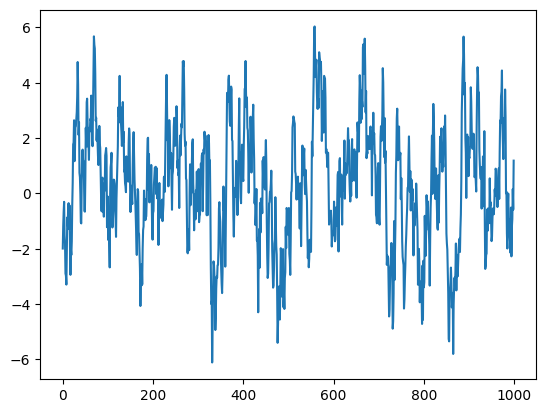

In [36]:
import numpy as np
import statsmodels.api as sm

# Definimos el modelo SARIMAX con coeficientes AR, MA, SAR, SMA
mod = sm.tsa.SARIMAX(endog=[], order=(1, 0, 0), seasonal_order=(1, 0, 0, 25))

# Debemos incluir al menos 5 parámetros
params = [0.9,0,0.9,0]  # AR, MA, SAR, SMA, Constante (por ejemplo)

# Generamos 100 simulaciones
sim_data = mod.simulate(params=params, nsimulations=1000, measurement_shock=10 * np.random.randn(100))

print(sim_data)
plt.plot(sim_data[:1000])

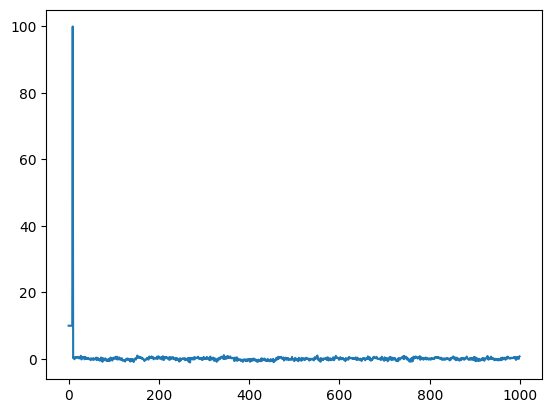

In [58]:
import numpy as np
import statsmodels.api as sm

initial_values = np.array([10, 10,10,10,10,10,10,10,10,100])

endog = np.concatenate([initial_values, [np.nan] * (1000 - len(initial_values))])

# Definimos el modelo SARIMAX con coeficientes AR, MA, SAR, SMA
mod = sm.tsa.SARIMAX(endog=endog, order=(4, 0, 0), seasonal_order=(1, 0, 0, len(initial_values)))

# Debemos incluir al menos 5 parámetros
params = [0.2,0.1,0.2,0.2,0,0.1,0]  # AR, MA, SAR, SMA, Constante (por ejemplo)

fitted_mod = mod.filter(params)

# Generamos 100 simulaciones
sim_data = fitted_mod.simulate(nsimulations=(1000 - len(initial_values)))

final_series = np.concatenate([initial_values, sim_data])

# Graficamos la serie completa
plt.plot(final_series[:])
plt.show()

## Graficar datos

## Seleccionar datos para modelo

# Definir Función

In [5]:
def LSTM_CON_PD(df,nodos,activacion,epocas,ventana,n_pred):


    paciencia = 5
    epocas = 80
    batch  = 32



    datos = df['AEP_MW'].to_numpy()
    fechas = df['Datetime'].to_numpy()
    datos = datos.reshape(-1,1)

    estandarizacion = MinMaxScaler().fit(datos)
    scaled_data = estandarizacion.transform(datos)



    # dividir en train, test
    X, y = [], []
    Xf,yf = [],[]

    for i in range(len(scaled_data) - ventana - n_pred):
        X.append(scaled_data[i:i+ventana])
        y.append(scaled_data[i+ventana:i+ventana+n_pred])

        Xf.append(fechas[i:i+ventana])
        yf.append(fechas[i+ventana:i+ventana+n_pred])

    X, y = np.array(X), np.array(y)
    Xf,yf = np.array(Xf),np.array(yf)




    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
    fecha_X_train, fecha_X_test, fecha_y_train, fecha_y_test = train_test_split(Xf, yf, test_size=0.1, shuffle=False)



        
    model = Sequential()

    model.add(LSTM(nodos,activation= activacion, input_shape=(ventana,1)))
    model.add(Dense(nodos, activation=activacion))
    model.add(Dense(n_pred , activation=activacion))

    model.compile(optimizer="Adam", loss='mse')

    early_stopping = EarlyStopping(monitor='loss', patience=paciencia, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=epocas,validation_split = 0.2, verbose=1, batch_size=batch,shuffle = False, callbacks=[early_stopping])


    # guardar los archivo a usar en la carpeta 
    rutaAGuardar = f'Modelo {nodos} - nodos1 - {nodos} - nodos2 - {epocas} Epocas.keras'
    model.save(rutaAGuardar)




    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoca')
    plt.ylabel('Error')
    plt.legend()

    
    y_hat = model.predict(X_test, verbose=1)
    y_hat = estandarizacion.inverse_transform(y_hat)


In [6]:
datos = dfModelo['AEP_MW'].to_numpy()
fechas = dfModelo['Datetime'].to_numpy()
datos = datos.reshape(-1,1)

estandarizacion = MinMaxScaler().fit(datos)
scaled_data = estandarizacion.transform(datos)

window_size = 168
t_pridiccion = 24


# dividir en train, test
X, y = [], []
Xf,yf = [],[]

for i in range(len(scaled_data) - window_size - t_pridiccion):
    X.append(scaled_data[i:i+window_size])
    y.append(scaled_data[i+window_size:i+window_size+t_pridiccion])

    Xf.append(fechas[i:i+window_size])
    yf.append(fechas[i+window_size:i+window_size+t_pridiccion])

X, y = np.array(X), np.array(y)
Xf,yf = np.array(Xf),np.array(yf)




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)


fecha_X_train, fecha_X_test, fecha_y_train, fecha_y_test = train_test_split(Xf, yf, test_size=0.1, shuffle=False)

In [7]:
len(X_train)*0.8

3008.0

In [8]:
len(X_train)*0.8/batch

NameError: name 'batch' is not defined

In [9]:
len(X_train)*0.8-92*32

64.0


Epoch 1/80

94/94 [==============================] - 14s 72ms/step - loss: 0.2290 - val_loss: 0.2717
Epoch 2/80
94/94 [==============================] - 5s 53ms/step - loss: 0.2282 - val_loss: 0.2708
Epoch 3/80
94/94 [==============================] - 5s 54ms/step - loss: 0.2274 - val_loss: 0.2700
Epoch 4/80
94/94 [==============================] - 6s 66ms/step - loss: 0.2267 - val_loss: 0.2691
Epoch 5/80
94/94 [==============================] - 6s 65ms/step - loss: 0.2260 - val_loss: 0.2682
Epoch 6/80
94/94 [==============================] - 6s 66ms/step - loss: 0.2252 - val_loss: 0.2674
Epoch 7/80
94/94 [==============================] - 6s 65ms/step - loss: 0.2245 - val_loss: 0.2666
Epoch 8/80
94/94 [==============================] - 6s 68ms/step - loss: 0.2238 - val_loss: 0.2658
Epoch 9/80
94/94 [==============================] - 6s 67ms/step - loss: 0.2232 - val_loss: 0.2651
Epoch 10/80
94/94 [==============================] - 7s 71ms/step - loss: 0.2226 - val_loss: 0.2643
Epoch 

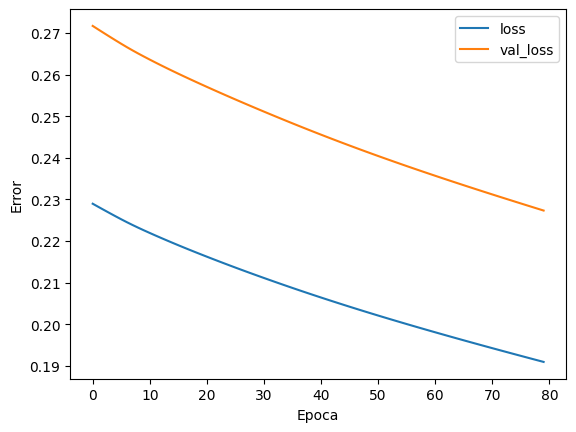

In [10]:
nodos1 = 50
nodos2 = 50
lr = 0.0001
paciencia = 5
epocas = 80
batch  = 32
window_size = 168
t_pridiccion = 24

model = Sequential()

model.add(LSTM(nodos1,activation= "tanh", input_shape=(window_size,1)))
model.add(Dense(nodos2, activation="relu"))
model.add(Dense(t_pridiccion , activation="linear"))

l2_norm_clip = 20
noise_multiplier = 0
num_microbatches = 4
learning_rate = 0.0001

if batch % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')



# agregar la privacidad diferencial en el optimizador 
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

# Función de pérdida para regresión
loss = tf.keras.losses.MeanSquaredError(reduction=tf.losses.Reduction.NONE)


model.compile(optimizer=optimizer, loss=loss)

early_stopping = EarlyStopping(monitor='loss', patience=paciencia, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=epocas,validation_split = 0.2, verbose=1, batch_size=batch,shuffle = False, callbacks=[early_stopping])


# guardar los archivo a usar en la carpeta 
rutaAGuardar = f'Modelo {nodos1} - nodos1 - {nodos2} - nodos2 - {epocas} Epocas con PD.keras'
model.save(rutaAGuardar)




plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.legend()

In [11]:

y_hat = model.predict(X_test, verbose=1)
y_hat = estandarizacion.inverse_transform(y_hat)


14/14 [==============================] - 1s 11ms/step


In [12]:
y_test1 = y_test.reshape(-1, 1)

y_test1 = estandarizacion.inverse_transform(y_test1)

y_test1 = y_test1.reshape(-1,24,1)


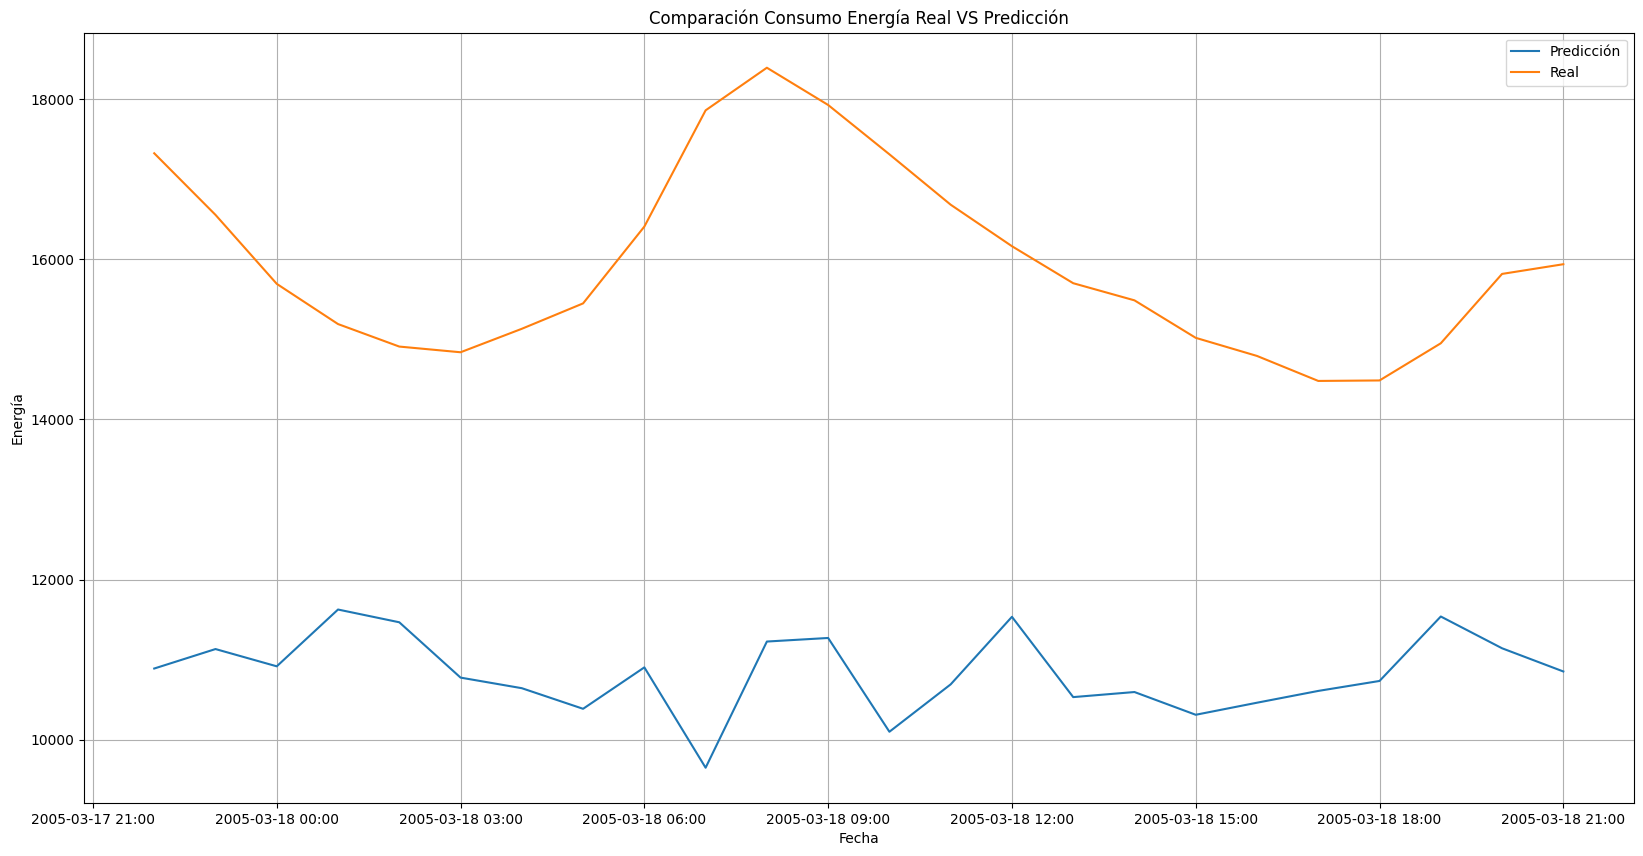

In [13]:

num = 100
plt.figure(figsize=(20,10))
plt.title("Comparación Consumo Energía Real VS Predicción")
#plt.plot(fecha_y_test[num], estandarizacion.inverse_transform(y_test[num]),label = "Real")
plt.plot(fecha_y_test[num],y_hat[num],label = "Predicción")
plt.plot(fecha_y_test[num],y_test1[num],label = "Real")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())



plt.ylabel("Energía")
plt.xlabel("Fecha")
plt.grid()
plt.legend()
plt.show()

In [22]:
X_train.shape[0]

3760

In [24]:
batch

32

In [25]:
noise_multiplier

0

In [26]:
epocas

80

In [29]:
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import compute_dp_sgd_privacy_statement

# Parámetros correctos para la función
epsilon = compute_dp_sgd_privacy_statement(
    number_of_examples = X_train.shape[0], # Aquí usamos 'num_examples' en lugar de 'n'
    batch_size=batch,
    noise_multiplier=30,
    delta=1e-5,
    num_epochs = epocas
)

print(f"Epsilon: {epsilon}")


Epsilon: DP-SGD performed over 3760 examples with 32 examples per iteration, noise
multiplier 30 for 80 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:         2.634
    Epsilon assuming Poisson sampling (*):                      0.199

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed that the actual epsilon
should be closer to this value than the conservative assumption of an arbitrary
data order.



# encontrar métricas

In [15]:
predicciones24 = []
reales24 = []
for i in range(24):
        
    pred = []
    for Predicciones in y_hat:
        pred.append(Predicciones[i])
        
    real = []
    for reales in y_test1:
        real.append(reales[i])
        
    predicciones24.append(pred)
    reales24.append(real)
    



MAES = {}
RMSE = {}
ER_Medios = {}
ER_Medianos = {}
epsilon = 1e-10
for i in range(24):
    MAE = round(mean_absolute_error(predicciones24[i],reales24[i]),2)
    MSE = round(mean_squared_error(reales24[0],predicciones24[i]),2)
    Error_Relativo_Medio = round((np.mean(np.abs((np.array(reales24[i]) - np.array(predicciones24[i])) / (np.array(reales24[i])+epsilon)))*100),2)
    Error_Relativo_Mediano = round((np.median(np.abs((np.array(reales24[i]) - np.array(predicciones24[i])) / (np.array(reales24[i])+epsilon)))*100),2)
    
    
    MAES[i] = MAE
    RMSE[i] = np.sqrt(MSE)
    ER_Medianos[i] = Error_Relativo_Mediano
    ER_Medios[i] = Error_Relativo_Medio

In [16]:
MAES

{0: 4508.62,
 1: 4224.9,
 2: 4457.39,
 3: 3809.43,
 4: 3951.97,
 5: 4535.62,
 6: 4619.35,
 7: 4864.74,
 8: 4391.85,
 9: 5506.49,
 10: 4158.69,
 11: 4163.5,
 12: 5118.72,
 13: 4546.83,
 14: 3884.32,
 15: 4693.04,
 16: 4649.35,
 17: 4870.41,
 18: 4734.58,
 19: 4606.91,
 20: 4565.0,
 21: 3817.32,
 22: 4146.74,
 23: 4401.67}

In [17]:
RMSE

{0: 4746.2776025007215,
 1: 4492.412267368168,
 2: 4715.884793970268,
 3: 4100.681231210248,
 4: 4244.271558229987,
 5: 4822.03944716341,
 6: 4907.870554527696,
 7: 5146.271376443337,
 8: 4687.183734397448,
 9: 5771.429175689502,
 10: 4447.071135028087,
 11: 4438.154669454412,
 12: 5389.313780992901,
 13: 4845.064941773227,
 14: 4187.103958585218,
 15: 4996.100168131139,
 16: 4960.065426987833,
 17: 5182.139640148652,
 18: 5056.862228694787,
 19: 4935.769370625009,
 20: 4882.575329680025,
 21: 4174.911727210529,
 22: 4503.742816813588,
 23: 4759.828109291343}

In [18]:
ER_Medianos

{0: 29.66,
 1: 27.86,
 2: 29.36,
 3: 25.11,
 4: 26.04,
 5: 29.91,
 6: 30.46,
 7: 32.02,
 8: 29.0,
 9: 36.17,
 10: 27.4,
 11: 27.42,
 12: 33.67,
 13: 29.95,
 14: 25.57,
 15: 30.92,
 16: 30.67,
 17: 32.12,
 18: 31.25,
 19: 30.46,
 20: 30.12,
 21: 25.21,
 22: 27.4,
 23: 29.03}

In [19]:
ER_Medios

{0: 28.7,
 1: 26.83,
 2: 28.37,
 3: 24.11,
 4: 25.06,
 5: 28.93,
 6: 29.49,
 7: 31.11,
 8: 27.98,
 9: 35.35,
 10: 26.43,
 11: 26.46,
 12: 32.78,
 13: 29.0,
 14: 24.64,
 15: 30.02,
 16: 29.75,
 17: 31.23,
 18: 30.35,
 19: 29.51,
 20: 29.25,
 21: 24.31,
 22: 26.5,
 23: 28.2}

In [20]:
y_hat

array([[10784.844, 11069.671, 10810.933, ..., 11349.358, 11037.948,
        10789.655],
       [10795.675, 11072.54 , 10818.667, ..., 11357.079, 11040.977,
        10788.717],
       [10811.226, 11077.432, 10835.386, ..., 11371.21 , 11048.167,
        10789.455],
       ...,
       [10771.038, 11069.794, 10803.936, ..., 11348.347, 11041.523,
        10793.002],
       [10739.976, 11051.664, 10782.327, ..., 11312.85 , 11021.35 ,
        10796.061],
       [10711.39 , 11030.801, 10763.342, ..., 11273.209, 10995.512,
        10798.085]], dtype=float32)

# Imprimir todas las predicciones

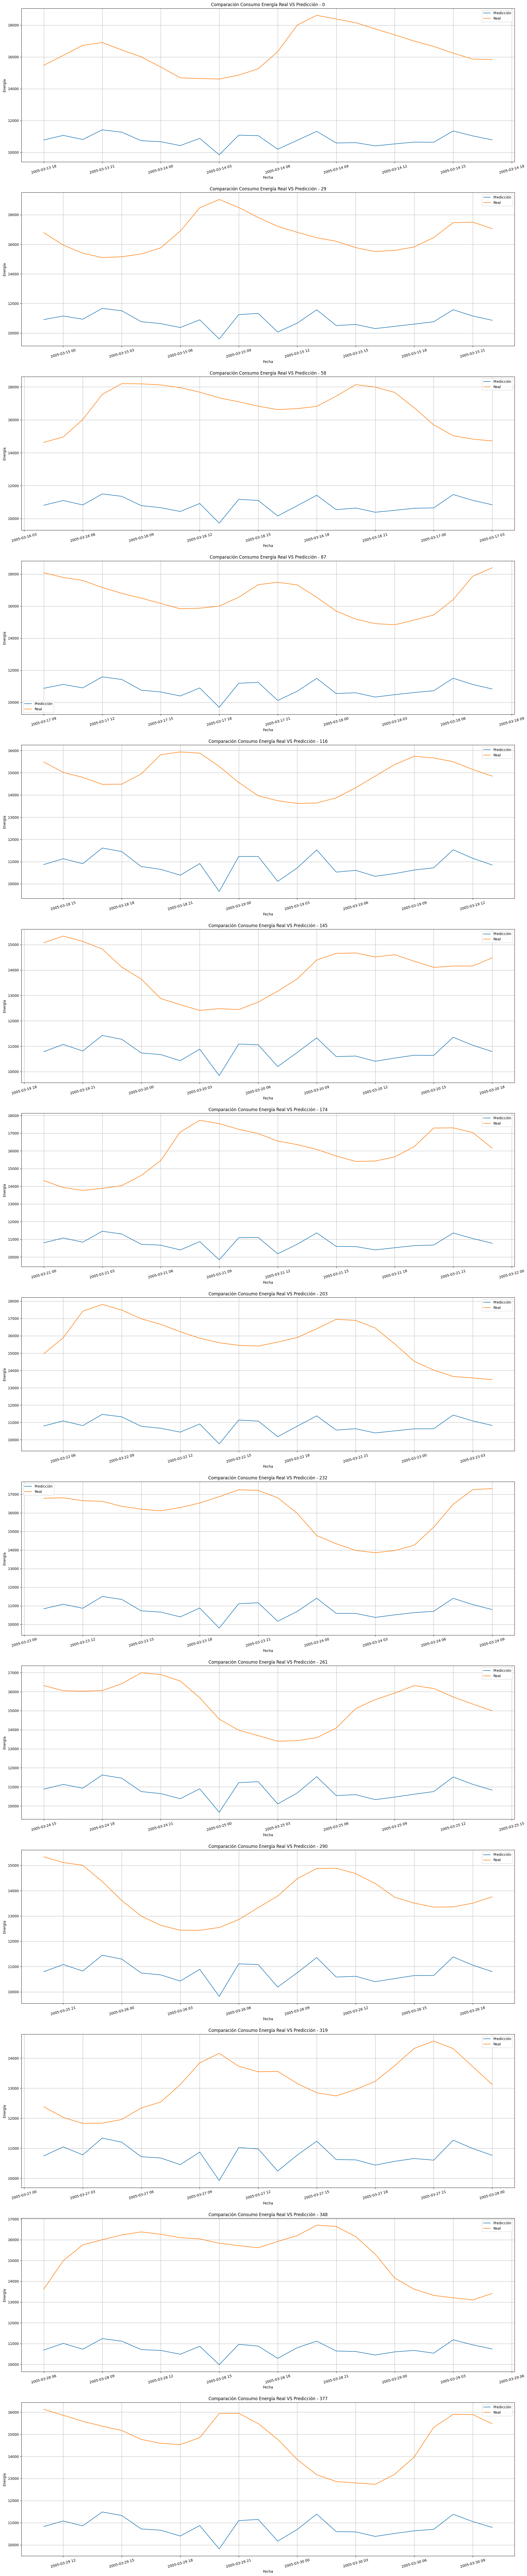

In [21]:
fig = plt.figure(figsize=(25, 130))
ax = fig.subplots(14,1)

for i in range(14):
    ax[i].set_title(f'Comparación Consumo Energía Real VS Predicción - {29*i}')
    ax[i].set_xlabel("Fecha")
    ax[i].set_ylabel("Energía")
    ax[i].plot(fecha_y_test[29*(i)],y_hat[29*(i)],label = "Predicción")
    ax[i].plot(fecha_y_test[29*(i)],estandarizacion.inverse_transform(y_test[29*(i)]),label = "Real")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H'))
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=15)
    ax[i].legend()
    ax[i].grid()
    
